In [107]:
import sklearn
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import pickle

import warnings
warnings.filterwarnings('ignore')

In [172]:
conn = sqlite3.connect('../db.sqlite3')

In [249]:
df_raw = pd.read_sql_query("SELECT * FROM scraper_auto", conn)

In [250]:
df_raw

,id,kenteken,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,prijs,url,titel,upload_datum,bron,apk
0,1159,96-GZR-3,2008,117910,77,0,1,1.0,https://www.marktplaats.nl/a/auto-s/fiat/m1554...,Fiat Grande Punto 1.4 Edizione Lusso AUTOMAAT!,2020-05-23 15:01:00,marktplaats,2021-05-22
1,1160,90-ZJ-ZN,2008,169504,78,0,1,2950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1556...,Fiat Grande Punto 1.4-16V Emotion 5dr Automaat...,2020-05-27 13:22:00,marktplaats,2020-10-18
2,1161,03-TR-LV,2007,219718,65,1,1,1950.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,"Fiat Grande Punto 1.2 Edizione Cool AIRCO,CRUI...",2020-06-01 16:00:00,marktplaats,2020-12-12
3,1162,61-TF-FP,2006,199908,95,1,1,1895.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.4-16V Emotion AIRCO/APK,2020-06-01 14:11:00,marktplaats,2021-01-17
4,1163,62-ZL-SX,2008,138191,65,1,1,2740.0,https://www.marktplaats.nl/a/auto-s/fiat/m1558...,Fiat Grande Punto 1.2 Active Airco_rijdt prima,2020-06-01 13:56:00,marktplaats,2021-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,1910,84ZNGL,2008,149336,77,1,0,3450.0,https://www.autoscout24.nl/aanbod/fiat-grande-...,Fiat Grande Punto1.4 Dynamic *NIEUW BINNEN*,None,autoscout,2020-05-28
717,1911,92PDH9,2011,190999,84,1,0,3450.0,https://www.autoscout24.nl/aanbod/fiat-punto-e...,Fiat Punto Evo1.3 M-Jet Dynamic / AIRCO / LMV ...,None,autoscout,2021-01-01
718,1912,HJ044H,2009,111000,77,1,1,3450.0,https://www.autoscout24.nl/aanbod/fiat-punto-1...,Fiat Punto1.4 Active,None,autoscout,2020-03-01
719,1913,58NKP8,2010,128835,86,1,0,3450.0,https://www.autoscout24.nl/aanbod/fiat-punto-e...,Fiat Punto Evo1.3 M-JET DYNAMIC,None,autoscout,2021-02-01


In [251]:
target_names = ["bouwjaar", "kilometer_stand", "vermogen", "prijs", "is_handgeschakeld", "is_benzine", "upload_datum", "apk"]


df = df_raw[target_names]

#df = pd.concat([pd.get_dummies(df['bron'], prefix='bron'), df], axis=1).drop(["bron"], axis=1)

In [252]:
df['upload_datum'] = pd.to_datetime(df['upload_datum'])
df['apk'] = pd.to_datetime(df['apk'])

average_upload_datum = df['upload_datum'].mean().toordinal()
average_apk =df['apk'].mean().toordinal()

def upload_datum_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_upload_datum)
    else:
        return abs(datetime.now().toordinal() - date.toordinal())
    
def apk_to_ordinal(date):
    if date is pd.NaT:
        return abs(datetime.now().toordinal() - average_apk)
    else:  
        return abs(datetime.now().toordinal() - date.toordinal())

df['upload_datum'] = df['upload_datum'].apply(upload_datum_to_ordinal).astype(int)
df['apk'] = df['apk'].apply(apk_to_ordinal).astype(int)

In [253]:
df['apk']

0      355
1      139
2      194
3      230
4      392
      ... 
716      4
717    214
718     92
719    245
720      4
Name: apk, Length: 721, dtype: int64

In [254]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [255]:
MIN_PRICE = 1000.
MAX_PRICE = 10000.

df_train = df_train[(df_train['prijs'] > MIN_PRICE) & (df_train['prijs'] < MAX_PRICE)]
df_test = df_test[(df_test['prijs'] > MIN_PRICE) & (df_test['prijs'] < MAX_PRICE)]

df_train

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum,apk
450,2014,49905,101,6995.0,1,1,11,146
357,2009,141940,67,4250.0,1,1,11,146
380,2009,135660,95,3940.0,1,1,11,146
145,2007,126737,77,3448.0,0,1,6,146
212,2006,167873,78,1995.0,1,1,11,1
...,...,...,...,...,...,...,...,...
700,2012,258709,84,2750.0,1,0,11,146
71,2007,139899,78,3490.0,1,1,3,360
106,2006,144791,78,2999.0,1,1,14,257
270,2011,171874,86,2748.0,1,0,14,274


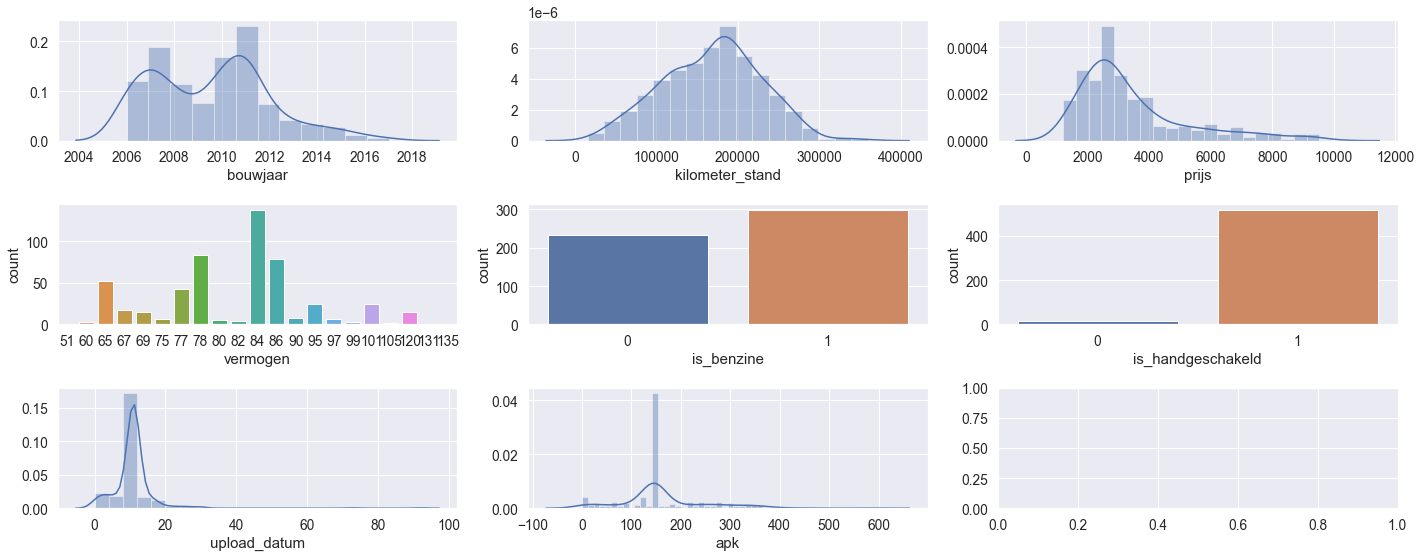

In [256]:
fig, axs = plt.subplots(3, 3, figsize=(20,8))

sns.distplot(df_train['bouwjaar'], ax=axs[0][0]);
sns.distplot(df_train['kilometer_stand'], ax=axs[0][1]);
sns.distplot(df_train['prijs'], ax=axs[0][2]);
sns.countplot(df_train['vermogen'], ax=axs[1][0]);
sns.countplot(df_train['is_benzine'], ax=axs[1][1]);
sns.countplot(df_train['is_handgeschakeld'], ax=axs[1][2]);
sns.distplot(df_train['upload_datum'], ax=axs[2][0]);
sns.distplot(df_train['apk'], ax=axs[2][1]);

plt.tight_layout()

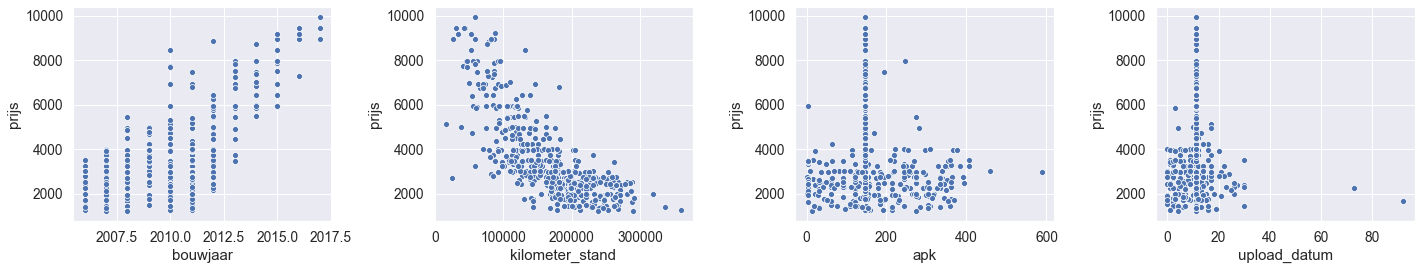

In [257]:
fig, axs = plt.subplots(1, 4, figsize=(20,4))

col = 'bouwjaar'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[0]);

col = 'kilometer_stand'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[1]);

col = 'apk'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[2]);

col = 'upload_datum'
data = pd.concat([df_train['prijs'], df_train[col]], axis=1)
sns.scatterplot(x=col, y='prijs', data=data, ax=axs[3]);

plt.tight_layout()

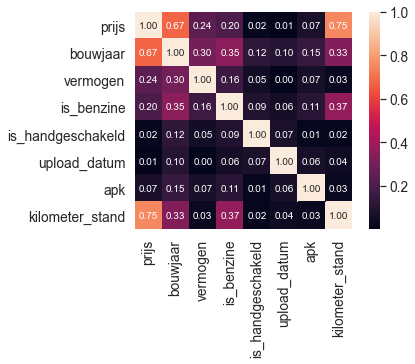

In [258]:
k = 10
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'prijs')['prijs'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
heatmap = sns.heatmap(np.absolute(cm), cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [259]:
df_train.to_pickle("./train_data.pkl")
df_test.to_pickle("./test_data.pkl")

In [260]:
df_train

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum,apk
450,2014,49905,101,6995.0,1,1,11,146
357,2009,141940,67,4250.0,1,1,11,146
380,2009,135660,95,3940.0,1,1,11,146
145,2007,126737,77,3448.0,0,1,6,146
212,2006,167873,78,1995.0,1,1,11,1
...,...,...,...,...,...,...,...,...
700,2012,258709,84,2750.0,1,0,11,146
71,2007,139899,78,3490.0,1,1,3,360
106,2006,144791,78,2999.0,1,1,14,257
270,2011,171874,86,2748.0,1,0,14,274
